In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
assert tf.__version__.startswith('2')
from tensorflow import keras
from tensorflow.keras import layers

C:\Users\offco\.conda\envs\tf2\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [4]:
IMAGE_PATH = r"C:\Users\offco\Documents\Dev_Projects\BookCoverClassifier\Datasets\Test_Run\Test_Augment"
IMAGE_SIZE = (256, 256)
BATCH_SIZE = 32
NUM_CLASSES = 5

train = tf.keras.preprocessing.image_dataset_from_directory(
    IMAGE_PATH,
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)
train = train.map(lambda x, y: (x, tf.one_hot(y, depth=NUM_CLASSES)))

validation = tf.keras.preprocessing.image_dataset_from_directory(
    IMAGE_PATH,
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)
validation = validation.map(lambda x, y: (x, tf.one_hot(y, depth=NUM_CLASSES)))

Found 254 files belonging to 5 classes.
Using 204 files for training.
Found 254 files belonging to 5 classes.
Using 50 files for validation.


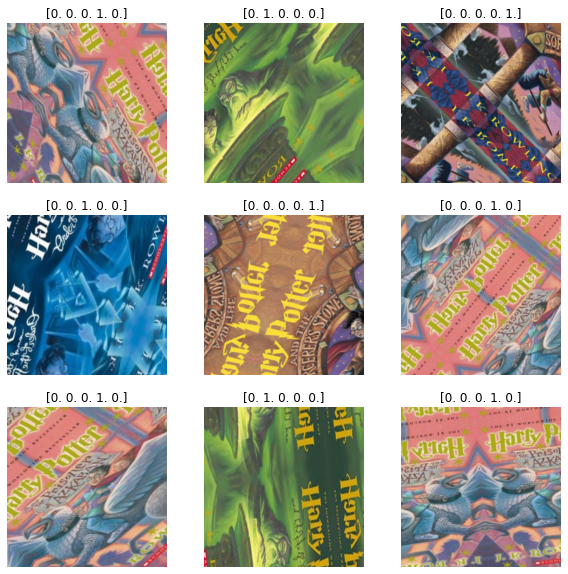

In [5]:
plt.figure(figsize=(10, 10))
for images, labels in train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(str(labels[i].numpy()))
        plt.axis("off")

In [6]:
train = train.prefetch(buffer_size=32)
validation = validation.prefetch(buffer_size=32)

In [17]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    
    rescaled = layers.Rescaling(1.0 / 255)(inputs)
    
    x = layers.Conv2D(32, 3, padding="same")(rescaled)
#     x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.MaxPooling2D(2, 2, padding="same")(x)
    
    x = layers.Conv2D(64, 3, padding="same")(x)
#     x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.MaxPooling2D(2, 2, padding="same")(x)
    
    x = layers.Conv2D(128, 3, padding="same")(x)
#     x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.MaxPooling2D(2, 2, padding="same")(x)
    
    x = layers.Dense(256, activation="relu")(x)
    
    x = layers.Flatten()(x)
    
    x = layers.Dense(1024, activation="relu")(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dense(16, activation="relu")(x)
    
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    
    return keras.Model(inputs, outputs)

model = make_model(input_shape=IMAGE_SIZE + (3,), num_classes=5)

In [7]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

model = make_model(input_shape=IMAGE_SIZE + (3,), num_classes=5)

In [18]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 rescaling_3 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 256, 256, 32)      896       
                                                                 
 re_lu_9 (ReLU)              (None, 256, 256, 32)      0         
                                                                 
 dropout_9 (Dropout)         (None, 256, 256, 32)      0         
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 128, 128, 32)     0         
 2D)                                                             
                                                           

In [19]:
epochs = 70

callbacks = [
    keras.callbacks.ModelCheckpoint(r"C:\Users\offco\Documents\Dev_Projects\BookCoverClassifier\Test_Run\Log\save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train, epochs=epochs, callbacks=callbacks, validation_data=validation,
)

Epoch 1/70
7/7 [==============================] - 5s 694ms/step - loss: 4.7319 - accuracy: 0.2157 - val_loss: 0.6821 - val_accuracy: 0.2800
Epoch 2/70
7/7 [==============================] - 4s 662ms/step - loss: 0.5544 - accuracy: 0.3039 - val_loss: 0.6790 - val_accuracy: 0.1200
Epoch 3/70
7/7 [==============================] - 4s 657ms/step - loss: 0.4934 - accuracy: 0.3873 - val_loss: 0.6687 - val_accuracy: 0.1200
Epoch 4/70
7/7 [==============================] - 4s 652ms/step - loss: 0.4776 - accuracy: 0.3922 - val_loss: 0.6657 - val_accuracy: 0.1200
Epoch 5/70
7/7 [==============================] - 4s 653ms/step - loss: 0.4717 - accuracy: 0.4118 - val_loss: 0.6632 - val_accuracy: 0.3000
Epoch 6/70
7/7 [==============================] - 4s 664ms/step - loss: 0.4696 - accuracy: 0.4118 - val_loss: 0.6594 - val_accuracy: 0.2200
Epoch 7/70
7/7 [==============================] - 4s 668ms/step - loss: 0.4711 - accuracy: 0.4118 - val_loss: 0.6371 - val_accuracy: 0.2600
Epoch 8/70
7/7 [====

7/7 [==============================] - 4s 680ms/step - loss: 1.8625e-05 - accuracy: 1.0000 - val_loss: 0.1553 - val_accuracy: 0.8400
Epoch 59/70
7/7 [==============================] - 4s 704ms/step - loss: 1.5545e-05 - accuracy: 1.0000 - val_loss: 0.1588 - val_accuracy: 0.8400
Epoch 60/70
7/7 [==============================] - 4s 712ms/step - loss: 1.1264e-05 - accuracy: 1.0000 - val_loss: 0.1537 - val_accuracy: 0.8400
Epoch 61/70
7/7 [==============================] - 4s 690ms/step - loss: 8.2874e-06 - accuracy: 1.0000 - val_loss: 0.1450 - val_accuracy: 0.8400
Epoch 62/70
7/7 [==============================] - 4s 681ms/step - loss: 6.0594e-06 - accuracy: 1.0000 - val_loss: 0.1477 - val_accuracy: 0.8400
Epoch 63/70
7/7 [==============================] - 4s 722ms/step - loss: 3.8859e-06 - accuracy: 1.0000 - val_loss: 0.1426 - val_accuracy: 0.8400
Epoch 64/70
7/7 [==============================] - 4s 659ms/step - loss: 2.6671e-06 - accuracy: 1.0000 - val_loss: 0.1322 - val_accuracy: 0.84

In [20]:
IMG1_PATH = r"C:\Users\offco\Documents\Dev_Projects\BookCoverClassifier\Datasets\Test_Run\Predict_Images\1.Harry_Potter_and_the_Half_Blood_Prince.jpg"

img1 = keras.preprocessing.image.load_img(
    IMG1_PATH, 
    target_size=IMAGE_SIZE
)
img1_array = keras.preprocessing.image.img_to_array(img1)
img1_array = tf.expand_dims(img1_array, 0)  # Create batch axis

IMG2_PATH = r"C:\Users\offco\Documents\Dev_Projects\BookCoverClassifier\Datasets\Test_Run\Predict_Images\IMG_0656.jpg"

img2 = keras.preprocessing.image.load_img(
    IMG2_PATH, 
    target_size=IMAGE_SIZE
)
img2_array = keras.preprocessing.image.img_to_array(img2)
img2_array = tf.expand_dims(img2_array, 0)  # Create batch axis

predictions1 = model.predict(img1_array)
score1 = predictions1[0]
print(np.where(score1 == score1.max()))

predictions2 = model.predict(img2_array)
score2 = predictions2[0]
print(np.where(score2 == score2.max()))

(array([1], dtype=int64),)
(array([3], dtype=int64),)


In [21]:
SAVE_PATH = r"C:\Users\offco\Documents\Dev_Projects\BookCoverClassifier\Test_Run\Model"
model.save(SAVE_PATH)

INFO:tensorflow:Assets written to: C:\Users\offco\Documents\Dev_Projects\BookCoverClassifier\Test_Run\Model\assets


In [28]:
model.save(SAVE_PATH + '\model.h5')

In [22]:
QMODEL_SAVE_PATH = r"C:\Users\offco\Documents\Dev_Projects\BookCoverClassifier\Test_Run\Quantized Model\quantized_model.tflite"

def representative_dataset():
    for data, label in train.take(30):
        yield [np.array(data, dtype=np.float32)]

converter = tf.lite.TFLiteConverter.from_saved_model(SAVE_PATH)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8
tflite_quant_model = converter.convert()

with open(QMODEL_SAVE_PATH, 'wb') as f:
    f.write(tflite_quant_model)

In [36]:
QMODEL_SAVE_PATH = r"C:\Users\offco\Documents\Dev_Projects\BookCoverClassifier\Test_Run\Quantized Model\quantized_model.tflite"

converter = tf.lite.TFLiteConverter.from_saved_model(SAVE_PATH)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float32]

tflite_quant_model = converter.convert()

with open(QMODEL_SAVE_PATH, 'wb') as f:
    f.write(tflite_quant_model)